# Machine Learning Project- Circuit Component Identification

Programmers: Tanzila Rahman (tr1106) and Nnamdi Nwaokorie (npn225)                                               
Class: EE-UY 4563 - Intro to Machine Learning                                                                     
Professor: Pr. Sundeep Rangan                                                            
Date: 22 December 2017                                                               

# Problem Formulation

Problem: Is it possible to take a picture of different circuit components and have a neural network 
         identify the difference between them?

Goal:  Our goal is to test a normal convolutional neural network on 8000 handwritten circuit component samples, 1600 for each of 
        the five circuit components used!  The five circuit components are (1) a resistor, (2) an independent volt source, (3) a 
        dependent volt source, (4) an independent current sources, and (5) a dependent current source!

# Review of Past Techniques

One team has attempted this same problem but instead of using a convolutional neural network, they implemented an artificial neural networks.  In addition, instead of identifying specific circuit components, they sought to indentify entire circuit composed of various components.  
The team's work can be seen here: http://www.sciencedirect.com/science/article/pii/S1877050916300783

# Our Solution

Below, our solution to this unique problem is presented!  

The steps to our solution are as follows:

(1) Create and test the images NOTE: Images can be found in the "Electronics" folder of this repository!                         
(2) Resize the images and Threshold them to black and white                                       
(3) Capture 8000 random images and keep track of the 8000 labels                                            
(4) Rescale the general data and create the training and testing datasets                                        
(5) Create the neural network and its model                                                                
(6) Test the neural network on the data                                                                                
(7) Create a Support Vector Machine (SVM) and test it on the data                                               



# Step 1: Load and Test the Images

In [1]:
import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

import librosa
import librosa.display
import librosa.feature

Using TensorFlow backend.


In [2]:
# Create a function plt_circuit that plots the circuit components.

def plt_circuit(img):
    nrow = 28
    ncol = 28
    img_sq = img.reshape((nrow,ncol))
    plt.imshow(img_sq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])


In [3]:
# Define our exception as follows which has an optional string argument.

class ImgException(Exception):
    def __init__(self, msg='No msg'):
        self.msg = msg

In [4]:
import matplotlib.image as mpimg
import skimage.io
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.transform import resize
import matplotlib.patches as mpatches
from skimage import data
import skimage

In [5]:
import os.path

# Create a function which can find and load the required image

def load_img(circ_ind, samp_ind):
    """
    Returns the image from the dataset given a circuit component and sample index.
    
        
    If the file doesn't exist, it raises an Exception with the filename.   
    """ 
    
    # TODO:  Set the file name based on circ_ind and samp_ind
    # fname = ...
    fname = "C:\\Users\\Nnamdi\\Documents\\Electronics\\Img\\Sample{0:03d}\\img{0:03d}- ({1:d}).JPEG".format(circ_ind, samp_ind)
    
    # TODO:  Use the os.path.isfile command to check if the file exists.  
    # If not raise an ImgException with the message "[fname] not found"
    if os.path.isfile(fname) == False:
        raise ImgException("%s not found" % fname)

    # TODO:  Use the skimage.io.imread() command to read the png file and return the image.
    # img = ...
    img = skimage.io.imread(fname)
    return img

Circ = 5 samp = 47
C:\Users\Nnamdi\Documents\Electronics\Img\Sample005\img005- (1670).JPEG not found


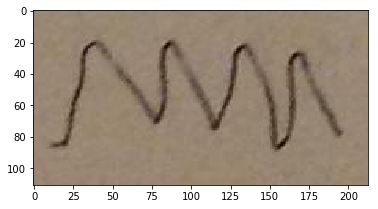

In [6]:
# Test the load_img function and make sure it works properly

circ_ind = 5
samp_inds = [47,1670]
for samp_ind in samp_inds:
    try:
        img = load_img(circ_ind=circ_ind, samp_ind=samp_ind)
        print("Circ = %d samp = %d" % (circ_ind, samp_ind))
        plt.imshow(img)
    except ImgException as e:
        print(e.msg)

# Step 2: Resize and Threshold the Images

In [7]:
# Complete the following method to find the image and place it in a 28 x 28 box.

def mnist_resize(img):
    """
    Extracts a circuit component from the image, and places in a 28x28 image to match the MNIST format.
    
    Returns:
    img1:  MNIST formatted 28 x 28 size image with the circuit component from img
    box:   A bounding box indicating the locations where the circuit component was found in img.    
    """
    # Image sizes (fixed for now).  To match the MNIST data, the image 
    # will be first resized to 20 x 20.  Then, the image will be placed in center of 28 x 28 box
    # offet by 4 on each side.
    nx_img = 20   
    ny_img = 20
    nx_box = 28   
    ny_box = 28
    offx = 4
    offy = 4
    
    # TODO:  Convert the image to gray scale using the skimage.color.rgb2gray method.
    # bw = ...
    bw = skimage.color.rgb2gray(img)
    
    # Threshold the image using OTSU threshold
    thresh = threshold_otsu(bw)
    bw = closing(bw < thresh, square(3)).astype(int)
    
    # Get the regions in the image.
    # This creates a list of regions in the image where the circuit component possibly is.
    regions = regionprops(bw)

    # TODO:  Find region with the largest area.  You can get the region area from region.area.
    # region_max = ...
    region_max = regions[0];
    area_max = 0
    for region in regions:
        if region.area > area_max:
            region_max = region
    area_max = region_max.area
    
    # Raise an ImgException if no region with area >= 100 was found
    if (area_max < 100):
        raise ImgException("No image found")    
                
    # Get the bounding box of the circuit component from region_max.bbox
    minr, minc, maxr, maxc = region_max.bbox
    box = [minr, minc, maxr, maxc]
    
    # TODO:  Crop the image in bw to the bounding box
    # bw_crop = bw[...]
    bw_crop = bw[minr:maxr, minc:maxc]
    
    # TODO:  Resize the cropped image to a 20x20 using the resize command.
    # You will need to use the mode = 'constant' option
    # bw_resize = ...
    bw_resize = skimage.transform.resize(bw_crop, (nx_img, ny_img), mode = 'constant')
    
    # TODO:  Threshold back to a 0-1 image by comparing the pixels to their mean value
    mean_value = skimage.filters.threshold_mean(bw_resize)
    bw_resize2 = bw_resize; 
    
    # Loop through the rows and columns of the bw_resize matrix
    for i in range(np.shape(bw_resize)[0]):
        for j in range(np.shape(bw_resize)[1]):
            # Set all values in the matrix less than the mean to zero
            if bw_resize[i, j] < mean_value:
                bw_resize2[i, j] = 0.0
            # Else, set those values to one
            else:
                bw_resize2[i, j] = 1.0

    # TODO:  Place extracted 20 x 20 image in larger image 28 x 28
    # img1 = ...
    img1 = np.zeros((nx_box, ny_box))
    img1[offx:-offx, offy:-offy] = bw_resize2
    
    return img1, box

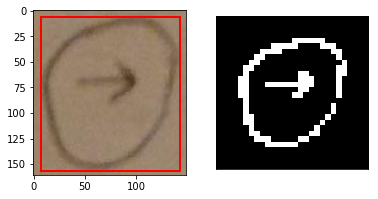

In [8]:
# Load an image
img = load_img(4, 1038)

try:
    
    # Resize the image
    img1, box = mnist_resize(img)
    #img1 = edge_detect_and_resize(img)
    
    # create figure and axes
    ax = plt.subplot(1, 2, 1)
    
    # Display the image
    ax.imshow(img)
    
    # TODO:  Plot the original image, img, along with a red box around the captured circuit component.
    # Use the mpatches.Rectangle and ax.add_patch methods to construct the rectangle.
    minr, minc, maxr, maxc = box
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # TODO:  Plot the resized 28 x 28 image, img1.  You can use the plt_circuit(img1) command 
    plt.subplot(1, 2, 2)
    plt_circuit(img1)
    
except ImgException as e:
    print(e.msg)

# Step 3: Randomly Capture and Appropriately Label 8000 Images

In [9]:
# Dimensions
ncirc = 8000   # 5 different circuit components * 1600 samples for each component
nrow = 28
ncol = 28
npix = nrow*ncol   # npix = 28*28 = 784
xcirc = np.zeros((ncirc, npix))
ylabels = np.array([]) 

i = 0

while i < ncirc:
    
    # TODO:  Generate a random circuit and sample    
    circ_ind = np.random.randint(1, 6)  # Get a random circuit component
    ylabels = np.append(ylabels, (circ_ind - 1)) # Get the labels for each circuit component
    
    # samp_ind = random number from 1 to 1600
    samp_ind = np.random.randint(1, 1600) #Each circuit component has 1600 samples to choose from
        
    try:
        # TODO:  Load the image with load_img function
        img = load_img(circ_ind, samp_ind)
        
        # TODO:  Reize the image with mnist_resize function
        img1, box = mnist_resize(img)

        # TODO:  Store the image in a row of xcirc[i,:] and increment i
        img2 = skimage.transform.resize(img1, (npix, 1), mode = 'constant') # Resize the img from (28, 28) to (784, 1)
        img2 = np.squeeze(img2) # Change image shape from (784, 1) to (784)
        xcirc[i, :] = img2
        i += 1
        
        # Print progress
        if (i % 500 == 0):
            print ('images captured = {0:d}'.format(i))
    except ImgException:
        # Skip if image loading or resizing failed
        pass

images captured = 500
images captured = 1000
images captured = 1500
images captured = 2000
images captured = 2500
images captured = 3000
images captured = 3500
images captured = 4000
images captured = 4500
images captured = 5000
images captured = 5500
images captured = 6000
images captured = 6500
images captured = 7000
images captured = 7500
images captured = 8000


In [10]:
# since this takes a long time to generate, save the matrix xcirc to a file xcirc.p using the pickle.dump command. 

import pickle
with open("xcirc.p", "wb") as fp:
    pickle.dump(xcirc, fp)

In [11]:
# Reload the data xcirc from the file xcirc.p

import pickle
with open( "xcirc.p", "rb" ) as fp:
    xcirc = pickle.load(fp)

# Step 4: Rescale the Data and Create Training and Testing Sets

In [12]:
# Rescale the circuit components xcirc to a new matrix xcirc = 2*xcircs-1 to make the pixel values go from -1 to 1.  
xcircs = 2*xcirc - 1

# Reassign the variables for convience
x = xcircs
y = ylabels

# Get 7000 training samples Xtr,ytr and 1000 test samples Xts,yts. Remember to randomly select them.
import random
rand = random.sample(range(8000), 8000)
tr_index = rand[0:7000]
ts_index = rand[7000:8000]

# TODO
xtr = x[tr_index, :]
ytr = y[tr_index]
xts = x[ts_index, :]
yts = y[ts_index]

# Step 5: Create the Neural Network and its Model

In [13]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [14]:
# TODO clear session
import keras.backend as K
K.clear_session()

In [15]:
# TODO: construct the model
nin = x.shape[1]           # dimension of input data
nh = 306                   # number of hidden units
nout = int(np.max(y)+1)    # number of outputs since ys = 0,1,...,nclasses-1
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

In [16]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 306)               240210    
_________________________________________________________________
output (Dense)               (None, 5)                 1535      
Total params: 241,745
Trainable params: 241,745
Non-trainable params: 0
_________________________________________________________________


In [17]:
# A callback is a class that is passed to the fit method. 
# Complete the LoadHistory callback class below to save the loss and validation accuracy.

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = np.array([])
        self.val_acc = np.array([])
        self.prt_period = 10

    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss = np.append(self.loss, logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        v = logs.get('val_acc')
        self.val_acc = np.append(self.val_acc, v)
        if (epoch % self.prt_period == 0):
            print('epoch = %d val_acc=%12.4e' % (epoch, v))
        
# Create an instance of the history callback
history_cb = LossHistory()

#  Step 6: Test the Neural Network on the Data

In [18]:
# Create an optimizer and compile the model. Select the appropriate loss function and metrics. 
# For the optimizer, use the Adam optimizer with a learning rate of 0.001

from keras import optimizers

# Since this is a multi-class classification problem, we select the sparse_categorial_crossentropy loss.
# It is sparse because the labels vector y is of shape [batch_size] instead of shape [batch_size, num_classes]
opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
# Fit the model for 10 epochs using the scaled data for both the training and validation.  
# Use the validation_data option to pass the test data. 
# Also, pass the callback class created above. Use a batch size of 100. 
# Your final accuracy should be >99%. 
batch_size = 100
model.fit(xtr, ytr, epochs=110, batch_size=batch_size, 
          validation_data=(xts, yts), callbacks=[history_cb],verbose=False)

epoch = 0 val_acc=  5.7200e-01
epoch = 10 val_acc=  6.6700e-01
epoch = 20 val_acc=  7.1300e-01
epoch = 30 val_acc=  7.2800e-01
epoch = 40 val_acc=  7.5900e-01
epoch = 50 val_acc=  7.6800e-01
epoch = 60 val_acc=  7.8000e-01
epoch = 70 val_acc=  7.8300e-01
epoch = 80 val_acc=  7.9900e-01
epoch = 90 val_acc=  7.8700e-01
epoch = 100 val_acc=  7.9200e-01


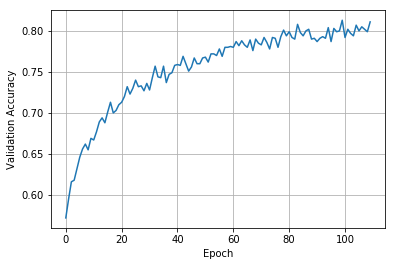

In [20]:
# Plot the validation accuracy saved in the history_cb. This gives one accuracy value per epoch. 
plt.plot( history_cb.val_acc, '-')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.grid()

# Step 7: Create a Support Vector Machine (SVM) and Test it on the Data

In [21]:
# First create the SVM classifer. Use an "rbf" classifier with C=2.8 and gamma=.0073.

from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073, verbose=10)

In [22]:
# Use the svc.fit command to fit on the training data.
svc.fit(xtr,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

In [23]:
# Measure the accuracy on the test samples. You should get about 96% accuracy.
yhat_ts = svc.predict(xts)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.773000


# Evaluation 

As can be seen above, both the Convolutional Neural Network and the Support Vector Machine were unable to obtain an accuracy greater than 80 percent! 

This may be do to several factors such as poor data due to inaequate pictures of the circuit components and poor thresholding of the data images!  

Ultimately, the this project could be improved by maybe finding a better way to threshold the images to black and white, resizing of the images differently to add resolution, and possibly scaling the data more efficiently.  